In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
train = pd.read_csv('E:/words_dataset/train.csv')
valid = pd.read_csv('E:/words_dataset/valid.csv')
train.head()

,Unnamed: 0,FILENAME,IDENTITY
0,0,ae_Nice_0.png,المتميزة
1,1,ae_Nice_1.png,لمساحات
2,2,ae_Nice_2.png,الغذائية
3,3,ae_Nice_3.png,الطولية
4,4,ae_Nice_4.png,الصانعون


In [3]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [4]:
def preprocess(img):
    
    (h, w) = img.shape
    
    final_img = np.ones([50, 50])*255 # blank white image
    
    # crop
    if w > 50:
        img = img[:, :50]
        
    if h > 50:
        img = img[:50, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [5]:
train_size = 50000
valid_size= 5000

In [6]:
train_x = []

for i in range(train_size):
    img_dir = 'E:/words_dataset/png_files_18_fonts_2160000 samples/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)
    


In [7]:
valid_x = []

for i in range(valid_size):
    img_dir = 'E:/words_dataset/png_files_18_fonts_2160000 samples/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)
    


In [8]:
train_x[0].shape

(50, 50)

In [9]:
train_x = np.array(train_x).reshape(-1, 50, 50, 1)
valid_x = np.array(valid_x).reshape(-1, 50, 50, 1)

In [26]:
alphabets = u"-ـ_ابتةثجحخدذرزسشصضطظعغفقكلمنهوى يءآأؤإئ"

max_str_len = 24 #25594 # max length of input labels

num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank

num_of_timestamps = 50 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [27]:
for i in range(len(train['IDENTITY'])):
    l=(label_to_num((train['IDENTITY'][i])))
    for j in l:
        if j < 0:
            print("I found negative in",i)

In [28]:
print(train['IDENTITY'][669])
print(label_to_num(train['IDENTITY'][669]))

معالجـات
[27 21  3 26  8  1  3  5]


In [29]:
print(label_to_num('ـ'))

[1]


In [30]:
train_y = np.ones([train_size, max_str_len]) * -1

train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)

train_output = np.zeros([train_size])


for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY']) 
print(train_y)

[[ 3. 26. 27. ... -1. -1. -1.]
 [26. 27. 15. ... -1. -1. -1.]
 [ 3. 26. 22. ... -1. -1. -1.]
 ...
 [ 3. 26. 38. ... -1. -1. -1.]
 [ 4.  3. 26. ... -1. -1. -1.]
 [36. 17. 19. ... -1. -1. -1.]]


In [31]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [32]:
input_data = Input(shape=(50, 50, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((72, 128)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50, 50, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 50, 50, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 50, 50, 32)        0         
                                                                 
 max1 (MaxPooling2D)         (None, 25, 25, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 25, 25, 64)        18496     
                                                           

In [33]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [34]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc',)([y_pred, labels, input_length, label_length,])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [35]:
print('train_x.shape',train_x.shape)
print('train_y.shape',train_y.shape)
print('train_x.shape',train_input_len.shape)
print('train_x.shape',train_label_len.shape)

train_x.shape (50000, 50, 50, 1)
train_y.shape (50000, 24)
train_x.shape (50000, 1)
train_x.shape (50000, 1)


In [78]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))



model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=9, batch_size=128,verbose=1)

Epoch 1/9
391/391 [==============================] - 2002s 5s/step - loss: 5.5459 - val_loss: 6.7044
Epoch 2/9
391/391 [==============================] - 1839s 5s/step - loss: 5.4885 - val_loss: 6.6995
Epoch 3/9
391/391 [==============================] - 1903s 5s/step - loss: 5.4177 - val_loss: 6.6539
Epoch 4/9
391/391 [==============================] - 1856s 5s/step - loss: 5.3753 - val_loss: 6.6840
Epoch 5/9
391/391 [==============================] - 1856s 5s/step - loss: 5.3148 - val_loss: 6.6232
Epoch 6/9
391/391 [==============================] - 1850s 5s/step - loss: 5.2657 - val_loss: 6.6077
Epoch 7/9
391/391 [==============================] - 1638s 4s/step - loss: 5.2068 - val_loss: 6.5854
Epoch 8/9
391/391 [==============================] - 1635s 4s/step - loss: 5.1624 - val_loss: 6.5937
Epoch 9/9
391/391 [==============================] - 1635s 4s/step - loss: 5.1053 - val_loss: 6.5832


In [79]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))
print(len(prediction[0]))


9


In [80]:
prediction

['واليوناتا',
 'وربونيلا',
 'اـنعـاـمة-م',
 'الكبلوتيكا',
 'ومناطقها',
 'ورابلكانا',
 'ويعلفانا',
 'والفجورا',
 'والـكواربا',
 'والمناقراتا',
 'وامحدتينحا-',
 'اتيفاستا',
 'واليعانـيا',
 'والتعويناتا',
 'والأمزرانا',
 'والفقوسفا',
 'والشهداءا',
 'والمساوية',
 'الماجنةاة',
 'والإسلامىسا',
 'الياهودسا',
 'والميساوةاةاة',
 'الومهرة',
 'والمثانيألا',
 'الجديدةاةاة',
 'والمواركاتا',
 'وأاسنيسا',
 'والدبيلة',
 'أرجانيبا',
 'والقرارما',
 'ويتيوسا',
 'والأوراسأا',
 'وإقصاءاتها',
 'والاستقطاباتا',
 'ومشـكولاسا',
 'محتويانا',
 'وغابتها',
 'وترجعوا',
 'واابوشتا',
 'السوغابةاة',
 'عزفلقدزةزا',
 'والتقتيلا',
 'والاختراسا',
 'الـشـلة',
 'المولينام',
 'وانشاءها',
 'لانتاجينا',
 'وأسقاقها',
 'واارطلاقرا',
 'والبنوارا',
 'كارينيا',
 'ومسكـولا',
 'وعتاماتها',
 'الـثابـة',
 'المستدمـة',
 'ريكجانا',
 'وتقبلهماقاةا',
 'اليزناتيناز',
 'والقوافرةا',
 'لنيلمانا',
 'ومشفاتها',
 'والمقترحماماة',
 'والمرقوبة',
 'اينسينغنا',
 'وامتجمعةا',
 'والمشرية',
 'واليروءاتا',
 'والتارزيسإا',
 'والطمبولطا',
 'والنداقية',
 '

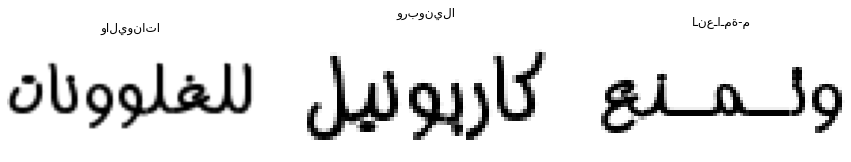

In [94]:
test = pd.read_csv('E:/words_dataset/valid.csv')

plt.figure(figsize=(15, 10))
for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'E:/words_dataset/png_files_18_fonts_2160000 samples/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 50, 50, 1))
    #print("pred",pred)
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# Model needs to be trained again with GPU to give better accuracy